In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Elements de correction

J'ai eu une longue echange avec un collegue a Paris
et je suis d'accord avec lui:

- si on considere les cas confirmes la deuxieme vague a commencee en France fin juin....
- les morts associees a la vague sont decalees d'un mois (un peu pres)

## Smoothing COVID data

So we'll see how a convolution works on real data.
We'll get the latest mortality figures from **GitHub**.

The [source](https://github.com/CSSEGISandData/COVID-19) is maintained by John Hopkins University.


In [5]:
! ../.g
country = 126

[master 0031b55] web
 2 files changed, 281 insertions(+), 5 deletions(-)
Counting objects: 5, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 39.89 KiB | 9.97 MiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   5c983a2..0031b55  master -> master


In [7]:
import requests
import pandas as pd

In [8]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)

## Visualising the data again

We'll convert to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

- If you want to know more [read this in french](http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Data_Manipulation_Pandas.pdf).
- It's basically a table like in Excel
    - columns have names
    - rows are numbered and accessed using ```iloc```.


In [9]:
df = pd.read_csv('covid_deaths.csv')

---

## List the countries with > 10000 dead

In [10]:
country = 126
df.iloc[country]

Province/State        NaN
Country/Region     France
Lat               46.2276
Long               2.2137
1/22/20                 0
                   ...   
11/15/20            44227
11/16/20            44731
11/17/20            45946
11/18/20            46366
11/19/20            46795
Name: 126, Length: 307, dtype: object

---

It's often easier to work with a numpy array of values

In [14]:
deaths = df.iloc[country][4:].values
ddf = pd.read_csv('covid_confirmed.csv')
cases =  ddf.iloc[country][4:].values
deaths[-1]

(deaths[-1] - deaths[150 + 33]) / (cases[-33] - cases[150])

0.025659359459654366

# Cumulative deaths

this looks pretty smooth

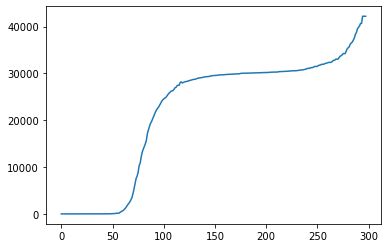

In [218]:
plt.plot(deaths);

Use ```np.diff``` to get daily death figures.

This is like differentiating the cumulative numbers.

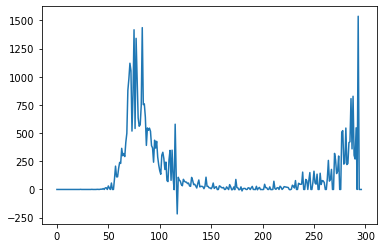

In [219]:
daily = np.diff(deaths,1)
plt.plot(daily);

Lets's look at the second wave

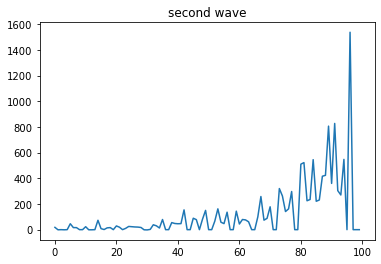

In [220]:
plt.plot(daily[-100:])
plt.title('second wave');

---

## Weekdays

The data noisy.


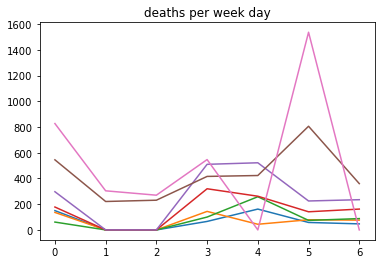

In [222]:
weeks = daily[-51:-2].reshape((-1,7))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per week day');

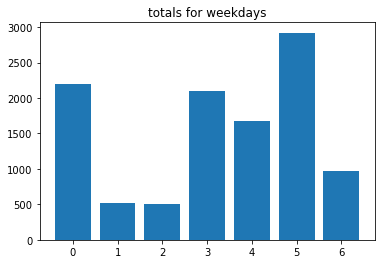

In [223]:
plt.bar(np.arange(7), np.sum(weeks, axis=0))
#plt.plot(np.sum(weeks, axis=0))
plt.title('totals for weekdays');

## Smoothing



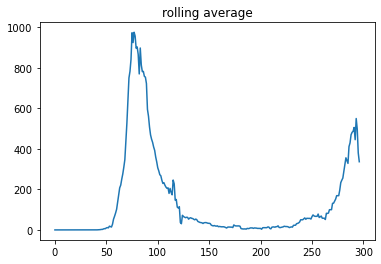

In [224]:
smooth_deaths = np.convolve(daily, np.ones(7)/7)[:-6]

plt.plot( smooth_deaths)
plt.title('rolling average');

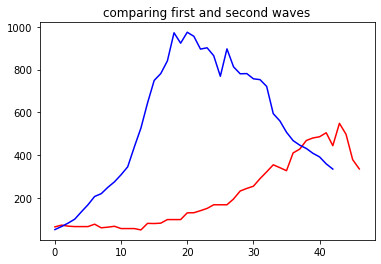

In [225]:
plt.plot(smooth_deaths[250:],'r')
plt.plot(smooth_deaths[57:100],'b');
plt.title('comparing first and second waves');

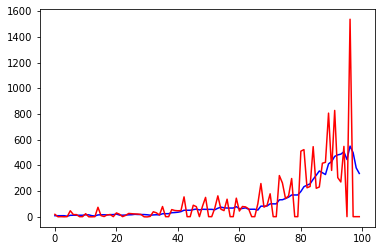

In [226]:
plt.plot(smooth_deaths[-100:],'b');
plt.plot(daily[-100:],'r');

---

## Kind of dumb but..

This is a heat map of the rvalue
to see where the fit is best.

<ipython-input-29-d4be8000462d>:3: RuntimeWarning: divide by zero encountered in log
  YY = np.log(smooth_deaths.tolist())


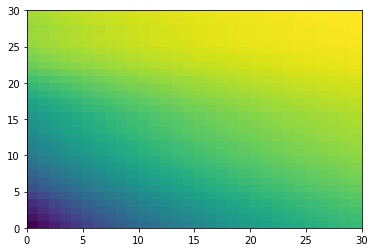

In [29]:
from scipy import stats
M = np.zeros((30,30))
YY = np.log(smooth_deaths.tolist())

for i, x in enumerate(range(185,215)):
    for j, y in enumerate(range(265,295)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue
        
        
plt.pcolor(M)
plt.show()

# Exponential  growth in deaths ?

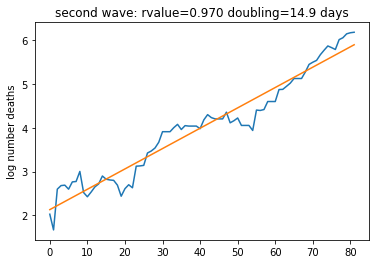

In [369]:
from scipy import stats

def regression_gph(Y, label='wave'):


    X = np.arange(len(Y))

    #plot raw data
    plt.plot(X,Y);

    #do regression
    coeffs = stats.linregress(X,Y)
    a,b = coeffs.slope, coeffs.intercept

    #plot regression curve
    plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
    plt.title('{}: rvalue={:.3f} doubling={:.1f} days'.format(label ,coeffs.rvalue, np.log(2)/a) )
    plt.ylabel('log number deaths')
    
Y =  np.log(smooth_deaths[209:-6].tolist())
regression_gph(Y, label='second wave')
    
    

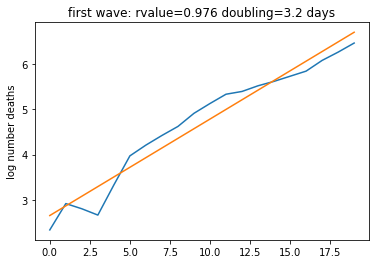

In [240]:
Y =  np.log(smooth_deaths[52:72].tolist())
regression_gph(Y, label='first wave')

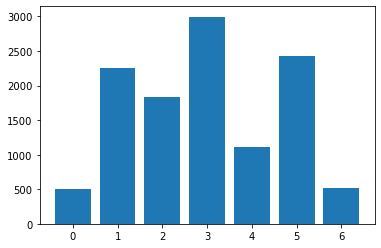

In [239]:
daily = daily[len(daily) % 7:]
weeks = daily.reshape(-1,7)
plt.bar(np.arange(7),weeks[-10:].sum(axis=0));

<ipython-input-233-fdaf7f16d11a>:4: RuntimeWarning: divide by zero encountered in log
  S = stats.linregress( X, np.log(daily[X].tolist() ) )
/home/macbuse/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
<ipython-input-233-fdaf7f16d11a>:6: RuntimeWarning: divide by zero encountered in log
  plt.plot( X, np.log(daily[X].tolist() ));


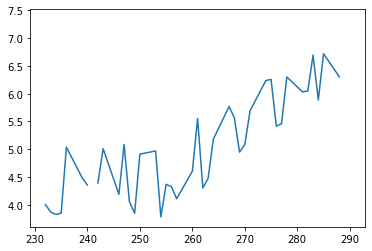

In [233]:
sample = [ k for k,r in enumerate(daily) if k % 7 not in [0,6]]

X = sample[-45:]
S = stats.linregress( X, np.log(daily[X].tolist() ) )

plt.plot( X, np.log(daily[X].tolist() ));

In [237]:
deaths[-7:]

array([40131, 40678, 40678, 42215, 42215, 42215, 42215], dtype=object)

In [189]:
np.log(2)/S.slope, S.rvalue


(12.839910118506085, 0.9778146472261677)

<ipython-input-238-40b5e1cf11b2>:4: RuntimeWarning: divide by zero encountered in log
  plt.plot( XX, np.log(daily[XX].tolist() ) + np.log(110), 'r', label='log deaths rescaled');
<ipython-input-238-40b5e1cf11b2>:9: RuntimeWarning: divide by zero encountered in log
  S = stats.linregress( XX, np.log(daily[XX].tolist() ) )
/home/macbuse/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


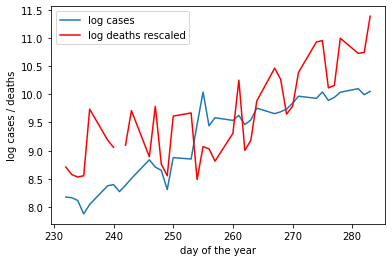

In [238]:

XX = X[:-7]

plt.plot( XX, np.log(daily_cases[XX].tolist() ), label='log cases' );
plt.plot( XX, np.log(daily[XX].tolist() ) + np.log(110), 'r', label='log deaths rescaled');
plt.xlabel('day of the year')
plt.ylabel('log cases / deaths')
plt.legend()

S = stats.linregress( XX, np.log(daily[XX].tolist() ) )


In [204]:
np.log(2)/S.slope

11.656835779537765

---

## That's great!!


The [doubling time](https://en.wikipedia.org/wiki/Doubling_time)
for the second wave is about 11 days !

For the first wave it was 3 days.



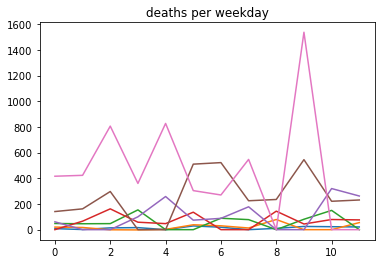

In [243]:
weeks = daily[-85:-1].reshape((-1,12))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per weekday');

---

## Confirmed cases

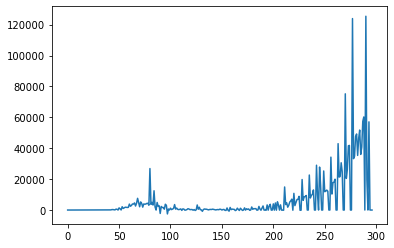

In [244]:
ddf = pd.read_csv('covid_confirmed.csv')

cases =  ddf.iloc[country][4:].values
daily_cases = np.diff(cases, 1)
plt.plot(daily_cases);

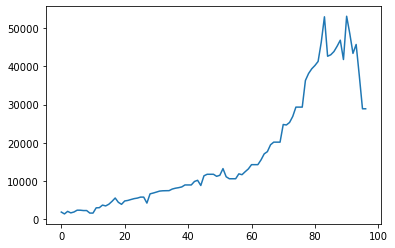

In [245]:
smoothed_cases = np.convolve(daily_cases, np.ones(7)/7)[:-6]
plt.plot(smoothed_cases[200:]);

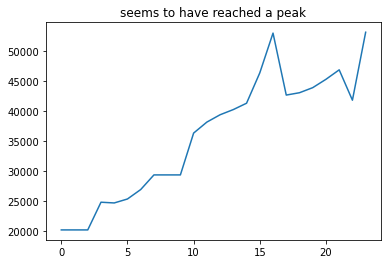

In [247]:
plt.plot(smoothed_cases[-30:-6]);
plt.title('seems to have reached a peak');

In [387]:
daily[170:190].tolist()

[-2, 89, 17, 14, -3, 0, 23, -13, 7, 9, 9, 0, 0, 15, 13, -1, 15, 27, 0, 0]

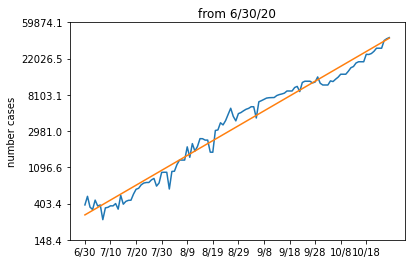

In [488]:
start = 160

Y = np.log(smoothed_cases[start:280].tolist())
regression_gph(Y, label='2nd wave')
plt.title('from {}'.format(df.columns[start+4]))
L = np.arange(5,10)
plt.yticks(L, 
           ['{:.1f}'.format(x ) for x in np.exp(L)] )

L = np.arange(5,12)
plt.yticks(L, 
           ['{:.1f}'.format(x ) for x in np.exp(L)] );
plt.ylabel('number cases');

L = np.arange(0,120,10)
plt.xticks(L, [x[:-3] for x in df.columns[ L + 4  + start ]  ]);

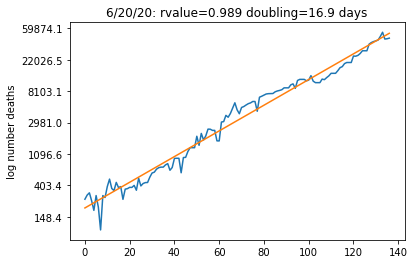

In [461]:
start = 150

Y =  np.log(smoothed_cases[start: -10].tolist())
regression_gph(Y, label=df.columns[start+4])
L = np.arange(5,12)
plt.yticks(L, 
           ['{:.1f}'.format(x ) for x in np.exp(L)] );

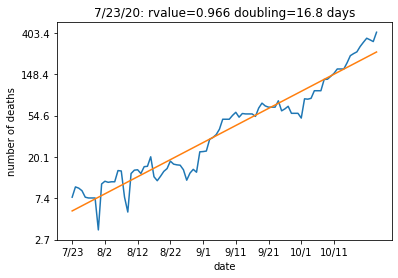

In [475]:
start = 150

Y =  np.log(smooth_deaths[start + 43: -10].tolist())
regression_gph(Y, label=df.columns[start+4 +33])
L = np.arange(1,7)
plt.yticks(L, 
           ['{:.1f}'.format(x ) for x in np.exp(L)] );
plt.ylabel('number of deaths')
plt.xlabel('date')
L = np.arange(0,90,10)
plt.xticks(L, [x[:-3] for x in df.columns[ L + 4 + 33 + start ]  ]);

In [11]:
(deaths[-1] - deaths[start +33]) / (cases[-33] - cases[start])

NameError: name 'deaths' is not defined

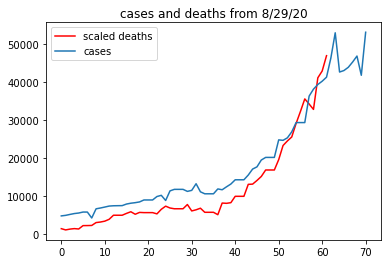

In [360]:
delay = 7

plt.plot( 100*smooth_deaths[220 + delay:-8],'r',label='scaled deaths')
plt.plot( smoothed_cases[220:-6],label='cases')
plt.title('cases and deaths from {}'.format(df.columns[224]))
plt.legend();

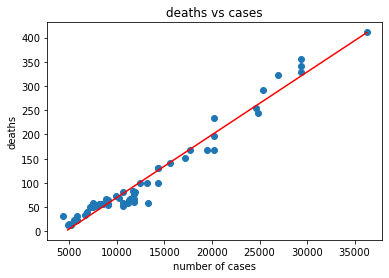

In [355]:
delay = 9

D = smooth_deaths[220 + delay:-10]
C = smoothed_cases[220:220+len(D)]

S = stats.linregress( C.tolist(), D.tolist())
a, b = S.slope, S.intercept

plt.scatter(C,D)
plt.plot( C[[0,-1]], a*C[[0,-1]] + b ,'r');
plt.xlabel('number of cases')
plt.ylabel('deaths')
plt.title('deaths vs cases');


In [356]:
S.rvalue, S.slope

(0.9814773826462376, 0.012945139748182259)

In [366]:
df.columns[224], daily[220:240].tolist()

('8/29/20',
 [21, 20, 17, -1, -2, 2, 38, 30, 13, 79, 0, 0, 55, 48, 46, 47, 154, 0, 0, 89])

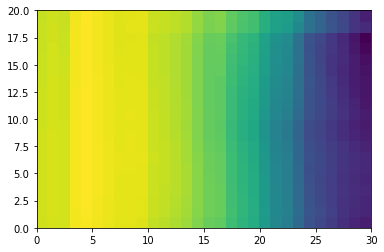

In [351]:
M = np.zeros((20,30))



for i, x  in enumerate(range(210,230)):
    for j in range(30):
        D = smooth_deaths[ x + j:-10].tolist()
        C = smoothed_cases[ x : x + len(D)].tolist()
      
        M[i ,j] = stats.linregress(C,D).rvalue
        
plt.pcolor(M)
plt.show()

In [353]:
np.where(M >.98)

(array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
         9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
        14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17,
        17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19]),
 array([3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4,
        5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5,
        6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6,
        7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7,
        8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8,
        9, 3, 4, 5, 6, 8, 9,

In [82]:
 df[ df.iloc[:,-1] > 10000 ].iloc[:,[1,-1]]

,Country/Region,11/14/20
6,Argentina,35307
23,Belgium,14303
30,Brazil,165658
55,Chile,14777
89,Colombia,33829
106,Ecuador,12997
126,France,42215
130,Germany,12511
143,India,129635
144,Indonesia,15148


# Mortality rate for the second wave

In [274]:
(deaths[-1] - deaths[200])/ (cases[-1] - cases[200])

0.007301319683295458

In [261]:
1/_

136.39806966009232

In [666]:
M = np.zeros((20,20))
YY = np.log(smoothed.tolist())

for i, x in enumerate(range(200,220)):
    for j, y in enumerate(range(270,290)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue

<ipython-input-666-49efe0b4dab3>:2: RuntimeWarning: divide by zero encountered in log
  YY = np.log(smoothed.tolist())


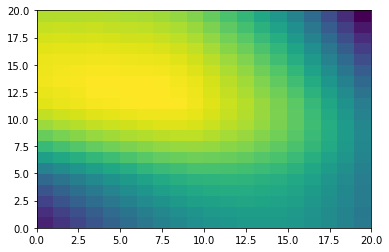

In [678]:
plt.pcolor(M)
plt.show()

In [342]:
! ../.g 

[master 7e9070c] web
 2 files changed, 372 insertions(+), 63 deletions(-)
Counting objects: 5, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 157.24 KiB | 1.83 MiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   67ca4b6..7e9070c  master -> master
